In [104]:
#KÜTÜPHANELER
import os
import csv
import random
import shutil

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from torchvision.models import densenet121, DenseNet121_Weights

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import label_binarize


In [33]:
#İŞLEM YAPILACAK DİZİNİ AYARLAMA
os.chdir(r"C:\Users\Eda EROL\OneDrive\veriset")

In [34]:
#GÖRSELLER İÇİN DİZİN AYARLARI
src_dirs = ["HAM10000_images_part_1", "HAM10000_images_part_2"]
dst_dir = "all_images"

In [35]:
#GÖRSEL KLASÖRÜNÜ OLUŞTUR
os.makedirs(dst_dir, exist_ok=True)

In [36]:
#RESİMLERİ TEK KLASÖRE BİRLEŞTİRME
for folder in src_dirs:
    for f in os.listdir(folder):
        src = os.path.join(folder, f)
        dst = os.path.join(dst_dir, f)
        if not os.path.exists(dst):
            shutil.copy(src, dst)

In [37]:
#SINIF ETİKETLERİNİ SAYILARA DÖNÜŞTÜRME
label_map = {
    "akiec": 0, "bcc": 1, "bkl": 2,
    "df": 3, "mel": 4, "nv": 5, "vasc": 6
}

In [38]:
#NUMARADAN LABEL'A EŞLEŞTİRME
idx_to_class = {v:k for k,v in label_map.items()}

In [39]:
#METADATA LİSTESİ OLUŞTURMA
metadata = []

In [40]:
#RESİM YOLLARI VE SINIF ETİKETLERİNİ LİSTEYE EKLEME
with open("HAM10000_metadata.csv", newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for r in reader:
        img = os.path.join(dst_dir, r["image_id"] + ".jpg")
        if os.path.exists(img):
            metadata.append((img, label_map[r["dx"]]))

In [41]:
#METADATA'DAN SADECE SINIF ETİKETLERİNİ ÇIKARMA
labels_all = [l for _, l in metadata]

In [42]:
#HER SINIF İÇİN ÖRNEK SAYISI
class_counts = np.bincount(labels_all)

In [43]:
print("Her sınıfın örnek sayısı:")
for i, count in enumerate(class_counts):
    print(f"Sınıf {idx_to_class[i]}: {count} görüntü")

Her sınıfın örnek sayısı:
Sınıf akiec: 327 görüntü
Sınıf bcc: 514 görüntü
Sınıf bkl: 1099 görüntü
Sınıf df: 115 görüntü
Sınıf mel: 1113 görüntü
Sınıf nv: 6705 görüntü
Sınıf vasc: 142 görüntü


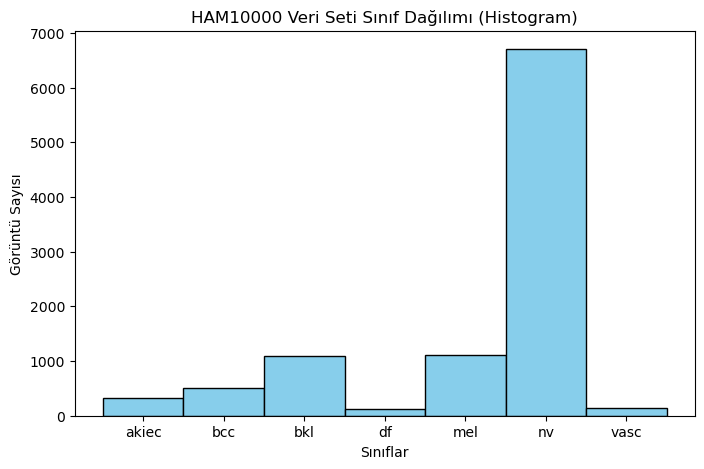

In [44]:
#HAM10000 VERİ SETİ SINIF DAĞILIMINI GÖSTERME-HİSTOGRAM GRAFİĞİ
plt.figure(figsize=(8,5))
plt.hist(labels_all, bins=np.arange(len(label_map)+1)-0.5, color='skyblue', edgecolor='black')  # Histogram binleri
plt.xticks(range(len(label_map)), idx_to_class.values())  # Sınıf isimlerini x-axis'e ekle
plt.xlabel("Sınıflar")
plt.ylabel("Görüntü Sayısı")
plt.title("HAM10000 Veri Seti Sınıf Dağılımı (Histogram)")
plt.show()

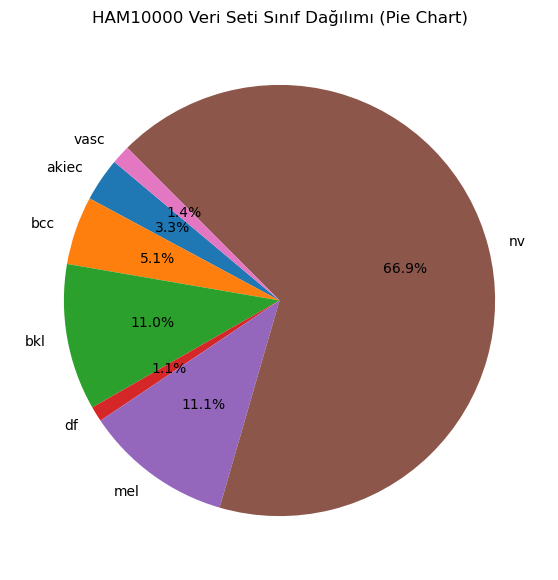

In [45]:
#HAM10000 VERİ SETİ SINIF DAĞILIMINI GÖSTERME-PIE CHART(PASTA GRAFİĞİ)
plt.figure(figsize=(7,7))
plt.pie(class_counts, labels=idx_to_class.values(), autopct="%1.1f%%", startangle=140)
plt.title("HAM10000 Veri Seti Sınıf Dağılımı (Pie Chart)")
plt.show()

In [46]:
#STRATIFIED K-FOLD SPLIT(TRAIN/VALIDATION/TEST)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [47]:
#VERİ YOLLARINI VE ETİKETLERİ NUMPY DİZİLERİNE ÇEVİRME(MODEL EĞİTİMİ İÇİN HAZIRLIK)
image_paths = np.array([p for p,_ in metadata])
labels = np.array([l for _,l in metadata])


In [48]:
#İLK FOLD İÇİN TRAIN-VAL VE TEST SPLIT OLUŞTURMA (STRATIFIED K-FOLD)
for train_val_idx, test_idx in skf.split(image_paths, labels):
    X_train_val, X_test = image_paths[train_val_idx], image_paths[test_idx]
    y_train_val, y_test = labels[train_val_idx], labels[test_idx]
    break  #Sadece ilk fold'u kullanıyoruz

In [49]:
#TRAIN/VALIDATION AYRIMI İÇİN STRATIFIED K-FOLD OLUŞTURMA
skf_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [50]:
#TRAIN-VAL AYRIMI İÇİN İLK FOLD’U SEÇME(STRATIFIED K-FOLD)
for train_idx, val_idx in skf_val.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
    break 

In [51]:
#DATA LOADER İÇİN TRAIN/VAL/TEST VERİLERİNİ TUPLE LİSTESİNE DÖNÜŞTÜRME
train_data = list(zip(X_train, y_train))
val_data   = list(zip(X_val, y_val))
test_data  = list(zip(X_test, y_test))

In [52]:
print("Train/Val/Test boyutları:", len(train_data), len(val_data), len(test_data))

Train/Val/Test boyutları: 6409 1603 2003


In [73]:
#MODEL GİRDİSİ İÇİN GÖRÜNTÜ BOYUTU (224x224)
IMG_SIZE = 224

In [74]:
#TRAIN SETİ İÇİN TRANSFORM(VERİ ARTTIRMA VE NORMALİZASYON)
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [75]:
#TEST/VALIDATION SETİ İÇİN TRANSFORM(NORMALİZASYON)
test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [76]:
#CİLT LEZYONU GÖRÜNTÜLERİ İÇİN CUSTOM DATASET
class SkinDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        img, y = self.data[i]
        img = Image.open(img).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, y


In [77]:
#TRAIN/VALIDATION/TEST DATASET OLUŞTURMA
train_dataset = SkinDataset(train_data, transform=train_tf)
val_dataset   = SkinDataset(val_data, transform=test_tf)
test_dataset  = SkinDataset(test_data, transform=test_tf)

In [78]:
#TRAIN/VALIDATION/TEST DATALOADER OLUŞTURMA
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) 
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [79]:
#TRAIN SETİNDEN SADECE SINIF ETİKETLERİNİ(LABELS) ÇIKARMA
train_labels = [l for _, l in train_data]

In [80]:
#HER SINIFTAKİ ÖRNEK SAYISINI SAYMA 
class_counts = np.bincount(train_labels)

In [81]:
#SINIF DENGESİ İÇİN CLASS WEIGHT HESAPLAMA (SIFIRA BÖLME ÖNLEMİYLE)
class_weights = 1. / class_counts 
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [82]:
#CİHAZ SEÇİMİ(GPU/CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [83]:
#DENSENET121 MODELİ TANIMLAMA (ÖNCEDEN EĞİTİLMİŞ AĞ AĞIRLIKLARI İLE)
model_weights = DenseNet121_Weights.DEFAULT
model = densenet121(weights=model_weights)

In [84]:
#SINIF SAYISINI BELİRLEME
num_classes = len(label_map)

In [85]:
#SECLASSIFIER KATMANINI SINIF SAYISINA GÖRE AYARLAMA VE CİHAZA TAŞIMA
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model = model.to(DEVICE)

In [87]:
#LOSS VE OPTIMIZER AYARLARI
criterion = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))  
optimizer = optim.Adam(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4   #overfitting azaltır
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.3,
    patience=2,
    )


In [88]:
#EĞİTİM PARAMETRELERİ VE KAYIT DEĞİŞKENLERİ
EPOCHS = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

In [89]:
#EARLY STOPPING SINIFI TANIMLAMA
class EarlyStopping:
    def __init__(self, patience=3):
        self.best = None
        self.wait = 0
        self.stop = False
        self.patience = patience

    def __call__(self, loss):
        if self.best is None or loss < self.best:
            self.best = loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stop = True

early = EarlyStopping(patience=3)

In [90]:
#EĞİTİM LOOPU(TRAIN+VALIDATION+EARLY STOPPING)
for epoch in range(EPOCHS):
    #TRAIN(EĞİTİM)
    model.train()
    running_loss, correct, total = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        correct += (outputs.argmax(1) == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #VALIDATION(DOĞRULAMA)
    model.eval()
    val_running_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            loss = criterion(outputs, y)

            val_running_loss += loss.item() * x.size(0)
            val_correct += (outputs.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    #EPOCH SONU EĞİTİM VE VALIDATION SONUÇLARINI EKRANA YAZDIRMA
    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} || "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f}"
    )
    scheduler.step(val_loss)

    #EARLY STOPPING KONTROLÜ VE EĞİTİMİN DURDURULMASI
    early(val_loss)
    if early.stop:
        print("Early stopping çalıştı")
        break

Epoch 1/10 | Train Loss: 1.1357 | Train Acc: 0.582 || Val Loss: 1.1410 | Val Acc: 0.604
Epoch 2/10 | Train Loss: 0.9647 | Train Acc: 0.640 || Val Loss: 0.7517 | Val Acc: 0.719
Epoch 3/10 | Train Loss: 0.7543 | Train Acc: 0.699 || Val Loss: 0.7624 | Val Acc: 0.696
Epoch 4/10 | Train Loss: 0.6624 | Train Acc: 0.727 || Val Loss: 0.8751 | Val Acc: 0.680
Epoch 5/10 | Train Loss: 0.6053 | Train Acc: 0.741 || Val Loss: 0.7123 | Val Acc: 0.714
Epoch 6/10 | Train Loss: 0.5066 | Train Acc: 0.770 || Val Loss: 0.6170 | Val Acc: 0.755
Epoch 7/10 | Train Loss: 0.4797 | Train Acc: 0.786 || Val Loss: 0.6544 | Val Acc: 0.739
Epoch 8/10 | Train Loss: 0.5359 | Train Acc: 0.769 || Val Loss: 0.8416 | Val Acc: 0.696
Epoch 9/10 | Train Loss: 0.4678 | Train Acc: 0.785 || Val Loss: 0.7829 | Val Acc: 0.686
Early stopping çalıştı


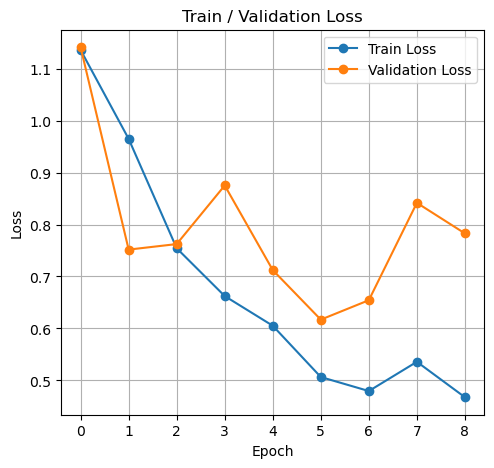

In [91]:
#TRAIN VE VALIDATION LOSS GRAFİĞİNİN OLUŞTURULMASI VE GÖSTERİLMESİ
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train / Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

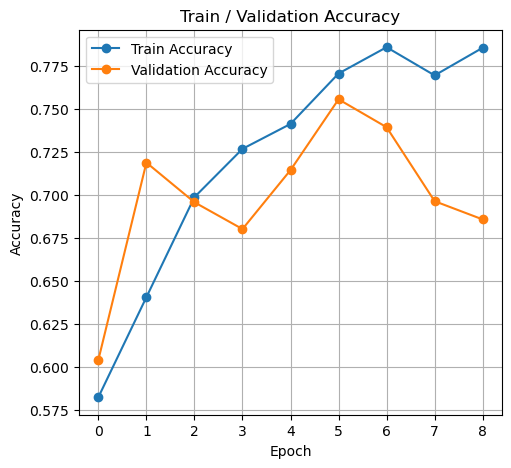

In [92]:
#TRAIN VE VALIDATION ACCURACY GRAFİĞİNİN OLUŞTURULMASI VE GÖSTERİLMESİ
plt.figure(figsize=(12,5))
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy', marker='o')
plt.plot(val_accs, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train / Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
#TEST VERİ SETİ ÜZERİNDE DOĞRULUK HESAPLAMA VE YAZDIRMA
test_accuracy = correct / total

In [94]:
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7855


In [95]:
#FINE-TUNING İÇİN TÜM AĞ AĞIRLIKLARINI EĞİTİLEBİLİR HALE GETİRME
for param in model.features.parameters():
    param.requires_grad = True

In [96]:
#FINE-TUNING İÇİN OPTIMIZER TANIMLAMA
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [97]:
#FINE-TUNING EĞİTİM PARAMETRELERİ VE EARLY STOPPING TANIMLAMA
EPOCHS_FINETUNE = 5
early = EarlyStopping(patience=3)

In [98]:
#FINE-TUNING EĞİTİM DÖNGÜSÜ:TRAIN,VALIDATION VE EARLY STOPPING
for epoch in range(EPOCHS_FINETUNE):
    #TRAIN(EĞİTİM)
    model.train()
    running_loss, correct, total = 0,0,0
    for x,y in train_loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*x.size(0)
        correct += (outputs.argmax(1)==y).sum().item()
        total += y.size(0)
    train_loss = running_loss/total
    train_acc  = correct/total

    #VALIDATION(DOĞRULAMA)
    model.eval()
    val_running_loss, val_correct, val_total = 0,0,0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            loss = criterion(outputs, y)
            val_running_loss += loss.item()*x.size(0)
            val_correct += (outputs.argmax(1)==y).sum().item()
            val_total += y.size(0)
    val_loss = val_running_loss/val_total
    val_acc  = val_correct/val_total
    
    #EPOCH SONU METRİKLERİNİN YAZDIRILMASI
    print(f"[Fine-Tune] Epoch {epoch+1}/{EPOCHS_FINETUNE} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} || Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    #EARLY STOPPING
    early(val_loss)
    if early.stop:
        print("Early stopping çalıştı (Fine-Tune)")
        break

[Fine-Tune] Epoch 1/5 | Train Loss: 0.3090 | Train Acc: 0.8337 || Val Loss: 0.4851 | Val Acc: 0.8035
[Fine-Tune] Epoch 2/5 | Train Loss: 0.2157 | Train Acc: 0.8705 || Val Loss: 0.4225 | Val Acc: 0.8465
[Fine-Tune] Epoch 3/5 | Train Loss: 0.1745 | Train Acc: 0.8933 || Val Loss: 0.4133 | Val Acc: 0.8497
[Fine-Tune] Epoch 4/5 | Train Loss: 0.1410 | Train Acc: 0.9098 || Val Loss: 0.4821 | Val Acc: 0.8303
[Fine-Tune] Epoch 5/5 | Train Loss: 0.1375 | Train Acc: 0.9126 || Val Loss: 0.4811 | Val Acc: 0.8278


In [100]:
#FİNAL TEST:MODELİN TEST VERİ SETİ ÜZERİNDE DEĞERLENDİRİLMESİ VE DOĞRULUK HESAPLAMA
model.eval()  #Modeli evaluation moduna al
test_correct = 0
test_total = 0

In [101]:
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)
        test_total += y.size(0)
        test_correct += (predicted == y).sum().item()

In [102]:
test_accuracy = test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Final Test Accuracy: 0.8038 (80.38%)


In [110]:
#TEST VERİ SETİ ÜZERİNDE MODEL TAHMİNLERİNİN VE OLASILIKLARININ TOPLANMASI
model.eval()
all_labels, all_preds, all_probs = [], [], []

In [111]:
with torch.no_grad():
    for x,y in test_loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        probs = torch.softmax(out,1)
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

In [108]:
#CONFUSION MATRIX HESAPLAMA
cm = confusion_matrix(all_labels, all_preds)

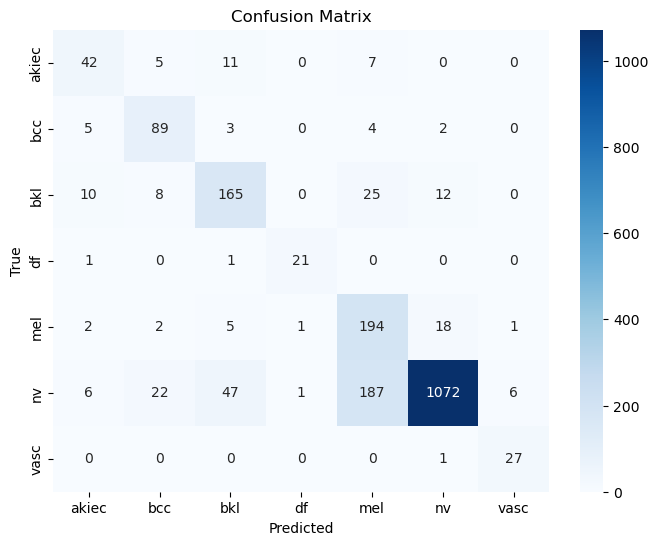

In [109]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=idx_to_class.values(),
            yticklabels=idx_to_class.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [112]:
#CLASSIFICATION REPORT
print(classification_report(
    all_labels, all_preds,
    target_names=idx_to_class.values()
))

              precision    recall  f1-score   support

       akiec       0.64      0.65      0.64        65
         bcc       0.71      0.86      0.78       103
         bkl       0.71      0.75      0.73       220
          df       0.91      0.91      0.91        23
         mel       0.47      0.87      0.61       223
          nv       0.97      0.80      0.88      1341
        vasc       0.79      0.96      0.87        28

    accuracy                           0.80      2003
   macro avg       0.74      0.83      0.77      2003
weighted avg       0.86      0.80      0.82      2003



In [113]:
#FİNAL TEST SETİ ROC HAZIRLIK
y_true = label_binarize(all_labels, classes=range(7))
y_score = np.array(all_probs)

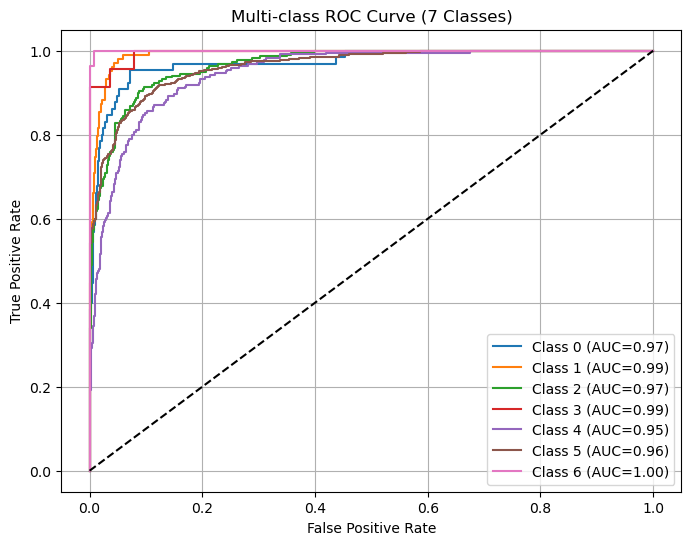

In [114]:
#MULTI-CLASS ROC GRAFİĞİ ÇİZME VE AUC DEĞERLERİNİ GÖSTERME
plt.figure(figsize=(8,6))
for i in range(7):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve (7 Classes)")
plt.legend()
plt.grid()
plt.show()

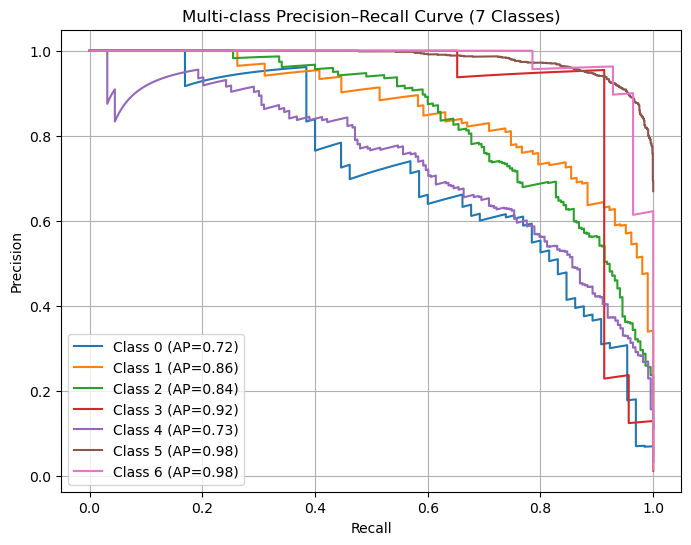

In [115]:
#MULTI-CLASS PRECISION-RECALL GRAFİĞİ ÇİZME VE AP DEĞERLERİNİ GÖSTERME
plt.figure(figsize=(8,6))
for i in range(7):
    precision, recall, _ = precision_recall_curve(
        y_true[:, i], y_score[:, i]
    )
    ap = average_precision_score(y_true[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"Class {i} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision–Recall Curve (7 Classes)")
plt.legend()
plt.grid()
plt.show()

In [116]:
#KANSER SINIFLARI(MALIGNANT LEZYONLAR)
#Kanser sınıfları: akiec=0, bcc=1, df=3, mel=4
cancer_classes = [0, 1, 3, 4]

In [119]:
#CANCER VE NON-CANCER BINARY LABEL OLUŞTURMA
binary_true = [1 if y in cancer_classes else 0 for y in all_labels]

In [120]:
#CANCER VE NON-CANCER OLASILIKLARINI HESAPLAMA
cancer_score = [sum(p[i] for i in cancer_classes) for p in all_probs]
noncancer_score = [1 - s for s in cancer_score]

In [121]:
#CANCER ROC AUC HESAPLAMA
fpr_c, tpr_c, _ = roc_curve(binary_true, cancer_score)
roc_auc_c = auc(fpr_c, tpr_c)

In [122]:
#NON-CANCER ROC AUC HESAPLAMA
fpr_nc, tpr_nc, _ = roc_curve([1 - b for b in binary_true], noncancer_score)
roc_auc_nc = auc(fpr_nc, tpr_nc)

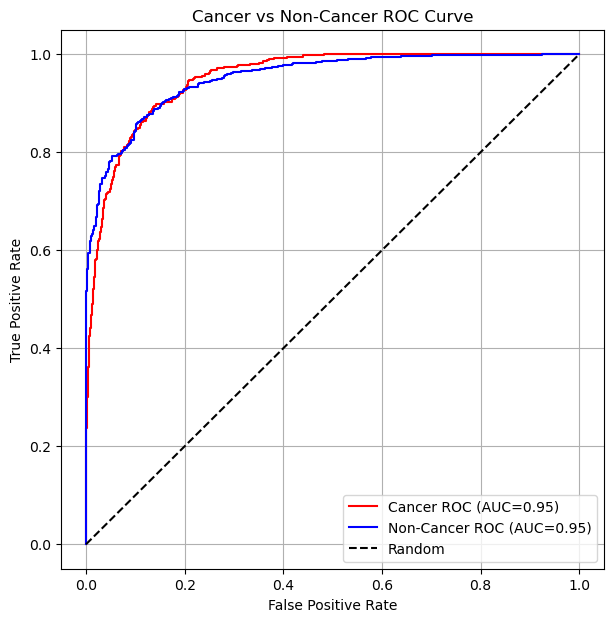

In [123]:
#CANCER VE NON-CANCER ROC GRAFİĞİ GÖSTERME
plt.figure(figsize=(7,7))
plt.plot(fpr_c, tpr_c, label=f"Cancer ROC (AUC={roc_auc_c:.2f})", color="red")
plt.plot(fpr_nc, tpr_nc, label=f"Non-Cancer ROC (AUC={roc_auc_nc:.2f})", color="blue")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Cancer vs Non-Cancer ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [124]:
#KANSER SINIFLARI İÇİN PRECISION-RECALL VE AP HESAPLAMA
precision_c, recall_c, _ = precision_recall_curve(binary_true, cancer_score)
pr_auc_c = average_precision_score(binary_true, cancer_score)

In [125]:
#KANSER DIŞI SINIFLAR İÇİN PRECISION-RECALL VE AP HESAPLAMA
precision_nc, recall_nc, _ = precision_recall_curve([1 - b for b in binary_true], noncancer_score)
pr_auc_nc = average_precision_score([1 - b for b in binary_true], noncancer_score)

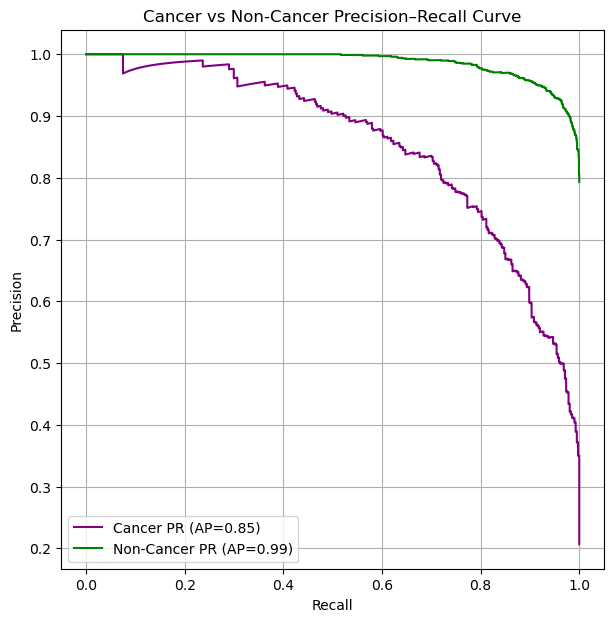

In [126]:
#KANSER VE KANSER DIŞI SINIFLAR İÇİN PRECISION-RECALL GRAFİĞİ ÇİZME
plt.figure(figsize=(7,7))
plt.plot(recall_c, precision_c, label=f"Cancer PR (AP={pr_auc_c:.2f})", color="purple")
plt.plot(recall_nc, precision_nc, label=f"Non-Cancer PR (AP={pr_auc_nc:.2f})", color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Cancer vs Non-Cancer Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

In [127]:
#SINIF İNDEKSİNE GÖRE KLİNİK KATEGORİ BELİRLEME FONKSİYONU
def clinical_output(class_idx):
    name = idx_to_class[class_idx]
    if name in ["mel", "bcc"]:
        return "Cancer"
    elif name == "akiec":
        return "Pre-cancer"
    else:
        return "Benign"

In [128]:
#İLK 10 ÖRNEK İÇİN GERÇEK VE TAHMİN EDİLEN KLİNİK KATEGORİLERİ GÖSTERME
for i in range(10):
    print(
        f"Gerçek: {clinical_output(all_labels[i])} | "
        f"Tahmin: {clinical_output(all_preds[i])}"
    )

Gerçek: Benign | Tahmin: Cancer
Gerçek: Benign | Tahmin: Benign
Gerçek: Benign | Tahmin: Benign
Gerçek: Benign | Tahmin: Cancer
Gerçek: Benign | Tahmin: Cancer
Gerçek: Benign | Tahmin: Benign
Gerçek: Benign | Tahmin: Benign
Gerçek: Benign | Tahmin: Benign
Gerçek: Benign | Tahmin: Benign
Gerçek: Benign | Tahmin: Benign


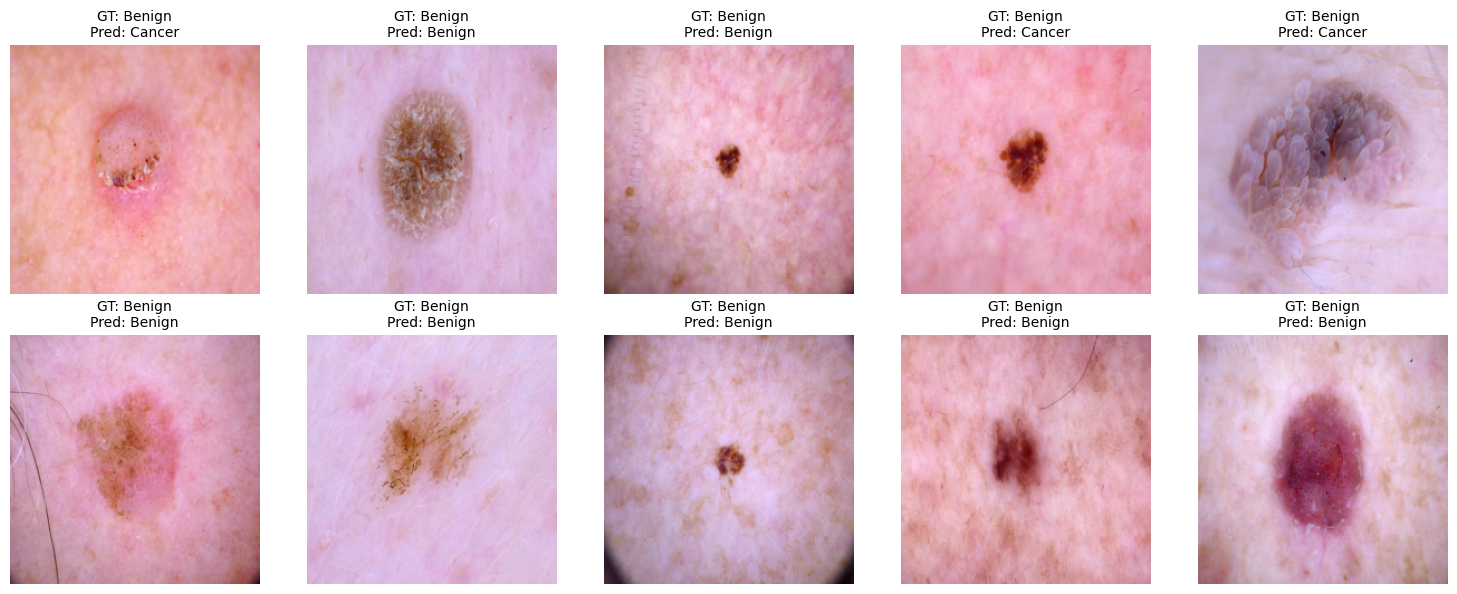

In [129]:
#GÖRÜNTÜLERİ GÖSTERME HAZIRLIĞI
def imshow(img):
    img = img.detach().permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.axis("off")

#TEST SETİNDEN İLK 10 ÖRNEK GÖRÜNTÜLERİN GÖSTERİMİ(GERÇEK VE TAHMİN ETİKETLERİ İLE)
model.eval()
shown = 0
plt.figure(figsize=(15, 6))

for images, labels in test_loader:
    images = images.to(DEVICE)
    images.requires_grad = True  #Grad-CAM veya gradient tabanlı işlemler için
    outputs = model(images)
    preds = outputs.argmax(1)

    for i in range(images.size(0)):
        if shown >= 10:
            break

        plt.subplot(2, 5, shown + 1)
        imshow(images[i])

        true_text = clinical_output(labels[i].item())
        pred_text = clinical_output(preds[i].item())

        plt.title(f"GT: {true_text}\nPred: {pred_text}", fontsize=10)
        shown += 1

    if shown >= 10:
        break

plt.tight_layout()
plt.show()

In [130]:
#Grad-CAM sınıfı 
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        target_layer.register_forward_hook(self.forward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output
        output.register_hook(self.save_gradient)

    def save_gradient(self, grad):
        self.gradients = grad

    def __call__(self, x, class_idx):
        out = self.model(x)
        self.model.zero_grad()
        out[:, class_idx].backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)

        cam = F.interpolate(
            cam.unsqueeze(1),
            size=x.shape[2:],
            mode="bilinear",
            align_corners=False
        )

        cam = cam.squeeze().detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

In [131]:
#GRAD-CAM ISI HARİTASINI GÖRÜNTÜ ÜZERİNE BİNDİRME FONKSİYONU
def show_cam_on_image(img, cam):
    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam), cv2.COLORMAP_JET
    )
    heatmap = np.float32(heatmap) / 255

    overlay = heatmap * 0.4 + img
    overlay = overlay / overlay.max()

    return overlay

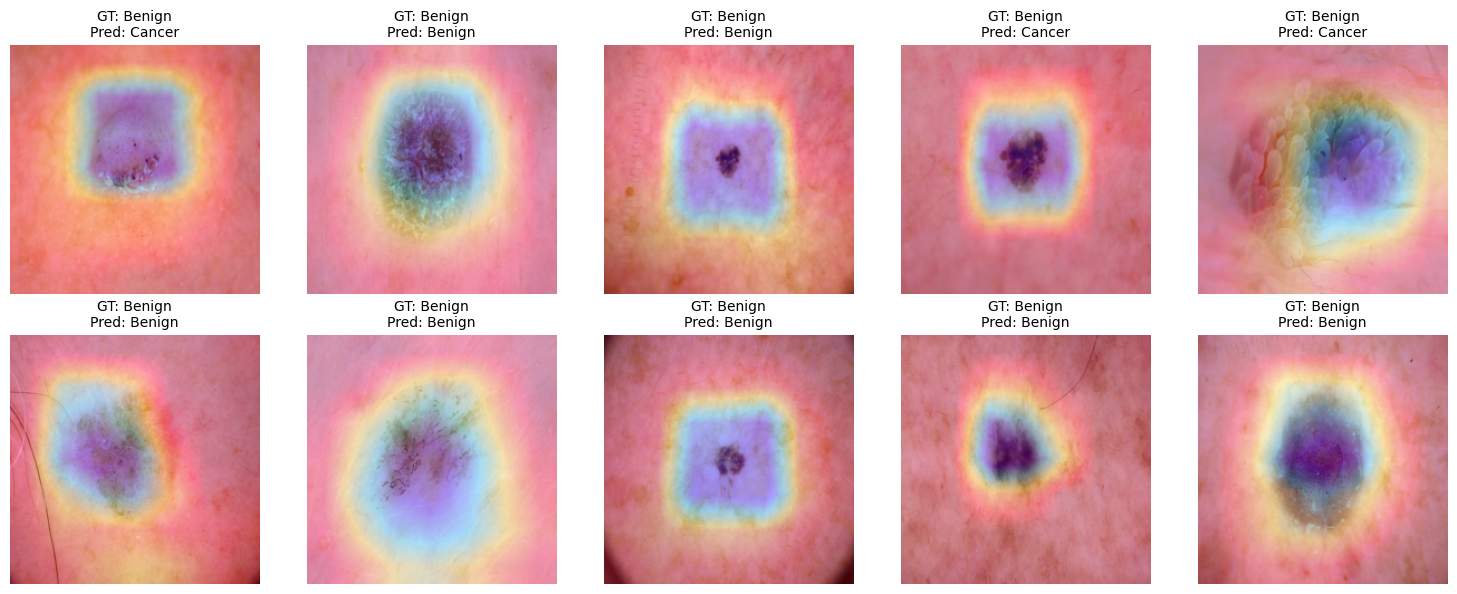

In [132]:
#GRAD-CAM İLE TEST GÖRÜNTÜLERİNİN ÜZERİNE ISI HARİTASI BİNDİRME VE GÖSTERİM
target_layer = model.features[-1]
gradcam = GradCAM(model, target_layer)

model.eval()
shown = 0
plt.figure(figsize=(15, 6))

for images, labels in test_loader:
    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(1)

    for i in range(images.size(0)):
        if shown >= 10:
            break

        cam = gradcam(images[i:i+1], preds[i].item())
        overlay = show_cam_on_image(images[i], cam)

        plt.subplot(2, 5, shown + 1)
        plt.imshow(overlay)
        plt.axis("off")

        plt.title(
            f"GT: {clinical_output(labels[i].item())}\n"
            f"Pred: {clinical_output(preds[i].item())}",
            fontsize=10
        )

        shown += 1

    if shown >= 10:
        break

plt.tight_layout()
plt.show()

In [133]:
#CANCER SINIFI İÇİN TRUE POSITIVE(TP) VE FALSE NEGATIVE(FN) SAYACINI BAŞLATMA
TP = 0
FN = 0

In [134]:
#CANCER SINIFI İÇİN FALSE NEGATIVE ORANINI HESAPLAMA
for y_true, y_pred in zip(all_labels, all_preds):
    true_clinic = clinical_output(y_true)
    pred_clinic = clinical_output(y_pred)

    # Gerçek Cancer ise
    if true_clinic == "Cancer":
        if pred_clinic == "Cancer":
            TP += 1
        else:
            FN += 1

fn_rate = FN / (TP + FN + 1e-8)

In [135]:
#CANCER SINIFI İÇİN TP,FN VE FALSE NEGATIVE ORANINI YAZDIRMA
print("Cancer FN (kaçırılan):", FN)
print("Cancer TP (yakalanan):", TP)
print(f"Cancer Kaçırma Oranı (FN Rate): %{fn_rate*100:.2f}")

Cancer FN (kaçırılan): 37
Cancer TP (yakalanan): 289
Cancer Kaçırma Oranı (FN Rate): %11.35
